In [29]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import scipy.stats as stats
import scipy.ndimage as ndimage
import pymannkendall as mk

In [30]:
# importing data
# numpy array with columns of date/time and num_value

PC_0192_details = pd.read_csv("Details_PC-0192.csv", sep=',')
PC_0192_details

,Project ID,birth_deid_date,death_deid_date,sex,icu_visit,icu_start_deid_dttm,icu_end_deid_dttm,failed_extubation_flag,failed_extubation_deid_date,intubation_flag,extubation_flag,extubation_deid_date,extubation_score,re_intubation_deid_date,icu_ward
0,PC0192,22/06/2004,NaN,Male,1,22/12/2016 11:53,18/02/2017 17:13,1,10/01/2017 18:00,1,1,28/12/2016 18:00,5,11/01/2017 14:00,FLAMI


In [31]:
# changing required fields to correct datetime data type to avoid string issues

PC_0192_details['failed_extubation_deid_date'] = pd.to_datetime(PC_0192_details['failed_extubation_deid_date'], format='%d/%m/%Y %H:%M')
PC_0192_details['re_intubation_deid_date'] = pd.to_datetime(PC_0192_details['re_intubation_deid_date'], format='%d/%m/%Y %H:%M')


In [32]:
failed_extubation = PC_0192_details.iloc[0,8]
re_intubation = PC_0192_details.iloc[0,13]

print(failed_extubation, re_intubation)

2017-01-10 18:00:00 2017-01-11 14:00:00


In [33]:
PC_0192_ABF_data = pd.read_csv("PC0192/PC0192_1_ABF.csv", sep=',')
PC_0192_ABF_data['record_date_time'] = pd.to_datetime(PC_0192_ABF_data['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_ABF_data


,monitor,record_date_time,num_value
0,ARTd,2016-12-26 18:36:04,70
1,ARTm,2016-12-26 18:36:04,85
2,ARTs,2016-12-26 18:36:04,121
3,ARTd,2016-12-26 18:36:09,71
4,ARTm,2016-12-26 18:36:09,87
...,...,...,...
1392312,ABPs,2017-01-23 15:08:05,132
1392313,ABPd,2017-01-23 15:08:09,62
1392314,ABPm,2017-01-23 15:08:09,82
1392315,ABPs,2017-01-23 15:08:09,124


In [34]:
failed_extubation_index = PC_0192_ABF_data.record_date_time.searchsorted(failed_extubation)
re_intubation_index = PC_0192_ABF_data.record_date_time.searchsorted(re_intubation)

print(failed_extubation_index, re_intubation_index)

PC_0192_ABF_extubated = PC_0192_ABF_data.iloc[failed_extubation_index+1:re_intubation_index-1, :]
PC_0192_ABF_extubated

745630 788214


,monitor,record_date_time,num_value
745631,ABPm,2017-01-10 18:00:01,114
745632,ABPs,2017-01-10 18:00:01,123
745633,ABPd,2017-01-10 18:00:06,106
745634,ABPm,2017-01-10 18:00:06,115
745635,ABPs,2017-01-10 18:00:06,123
...,...,...,...
788208,ABPd,2017-01-11 13:59:52,66
788209,ABPm,2017-01-11 13:59:52,83
788210,ABPs,2017-01-11 13:59:52,118
788211,ABPd,2017-01-11 13:59:56,67


In [35]:
# separating out the systolic, diastolic and mean data points

PC_0192_ABF_s_extubated = pd.DataFrame(columns=['monitor','record_date_time','num_value'])
PC_0192_ABF_d_extubated = pd.DataFrame(columns=['monitor','record_date_time','num_value'])
PC_0192_ABF_m_extubated = pd.DataFrame(columns=['monitor','record_date_time','num_value'])

for idx in PC_0192_ABF_extubated.index:
    if PC_0192_ABF_extubated['monitor'].loc[idx] == 'ABPs':
        PC_0192_ABF_s_extubated = PC_0192_ABF_s_extubated.append(PC_0192_ABF_extubated.loc[idx])
    if PC_0192_ABF_extubated['monitor'].loc[idx] == 'ABPd':
        PC_0192_ABF_d_extubated = PC_0192_ABF_d_extubated.append(PC_0192_ABF_extubated.loc[idx])
    if PC_0192_ABF_extubated['monitor'].loc[idx] == 'ABPm':
        PC_0192_ABF_m_extubated = PC_0192_ABF_m_extubated.append(PC_0192_ABF_extubated.loc[idx])

In [36]:
print(PC_0192_ABF_s_extubated)
print(PC_0192_ABF_d_extubated)
print(PC_0192_ABF_m_extubated)


       monitor    record_date_time num_value
745632    ABPs 2017-01-10 18:00:01       123
745635    ABPs 2017-01-10 18:00:06       123
745638    ABPs 2017-01-10 18:00:11       124
745641    ABPs 2017-01-10 18:00:16       124
745644    ABPs 2017-01-10 18:00:21       124
...        ...                 ...       ...
788198    ABPs 2017-01-11 13:59:32       120
788201    ABPs 2017-01-11 13:59:36       119
788204    ABPs 2017-01-11 13:59:42       118
788207    ABPs 2017-01-11 13:59:46       117
788210    ABPs 2017-01-11 13:59:52       118

[14171 rows x 3 columns]
       monitor    record_date_time num_value
745633    ABPd 2017-01-10 18:00:06       106
745636    ABPd 2017-01-10 18:00:11       105
745639    ABPd 2017-01-10 18:00:16       106
745642    ABPd 2017-01-10 18:00:21       105
745645    ABPd 2017-01-10 18:00:26       107
...        ...                 ...       ...
788199    ABPd 2017-01-11 13:59:36        67
788202    ABPd 2017-01-11 13:59:42        66
788205    ABPd 2017-01-11 13:

### Using systolic data

In [42]:
# fixing data types

PC_0192_ABF_s_extubated['record_date_time'] = pd.to_datetime(PC_0192_ABF_s_extubated['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_ABF_s_extubated['num_value'] = pd.to_numeric(PC_0192_ABF_s_extubated['num_value'])

PC_0192_ABF_d_extubated['record_date_time'] = pd.to_datetime(PC_0192_ABF_d_extubated['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_ABF_d_extubated['num_value'] = pd.to_numeric(PC_0192_ABF_d_extubated['num_value'])

PC_0192_ABF_m_extubated['record_date_time'] = pd.to_datetime(PC_0192_ABF_m_extubated['record_date_time'], format='%Y-%m-%d %H:%M:%S')
PC_0192_ABF_m_extubated['num_value'] = pd.to_numeric(PC_0192_ABF_m_extubated['num_value'])


In [43]:
ndimage.gaussian_filter1d(PC_0192_ABF_s_extubated['num_value'],sigma=100)

array([135, 135, 135, ..., 132, 132, 132])

In [44]:
# smoothing and subtracting to obtain residuals

PC_0192_ABF_s_extubated_smoothed = PC_0192_ABF_s_extubated.copy()
PC_0192_ABF_s_residuals = PC_0192_ABF_s_extubated.copy()
PC_0192_ABF_s_extubated_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_ABF_s_extubated['num_value'], sigma=100)
PC_0192_ABF_s_residuals['num_value'] = PC_0192_ABF_s_extubated['num_value'] - PC_0192_ABF_s_extubated_smoothed['num_value']
PC_0192_ABF_s_residuals

,monitor,record_date_time,num_value
745632,ABPs,2017-01-10 18:00:01,-12
745635,ABPs,2017-01-10 18:00:06,-12
745638,ABPs,2017-01-10 18:00:11,-11
745641,ABPs,2017-01-10 18:00:16,-11
745644,ABPs,2017-01-10 18:00:21,-11
...,...,...,...
788198,ABPs,2017-01-11 13:59:32,-12
788201,ABPs,2017-01-11 13:59:36,-13
788204,ABPs,2017-01-11 13:59:42,-14
788207,ABPs,2017-01-11 13:59:46,-15


### Removing anomalies

In [45]:
mu_residual = PC_0192_ABF_s_residuals['num_value'].mean()
sigma_residual = PC_0192_ABF_s_residuals['num_value'].std()

In [46]:
PC_0192_ABF_s_residuals_no_anomalies = PC_0192_ABF_s_residuals.copy()

for idx, val in enumerate(PC_0192_ABF_s_residuals_no_anomalies['num_value']):
    if not (mu_residual - 3*sigma_residual < val < mu_residual + 3*sigma_residual):
        if idx == 0:
            PC_0192_ABF_s_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_s_residuals['num_value'].iloc[idx+1]
        if idx == 14171:
            PC_0192_ABF_s_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_s_residuals['num_value'].iloc[idx-1]
        else:
            PC_0192_ABF_s_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_ABF_s_residuals['num_value'].iloc[idx+1] + PC_0192_ABF_s_residuals['num_value'].iloc[idx-1])


/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Functions

In [47]:
def rolling_mean(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','mean'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        mean = data['num_value'][index_1:index_2].mean()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'mean':mean}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['mean']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['mean'] = pd.to_numeric(df['mean'])

    df.plot(x='start_time', y='mean', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['mean'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['mean'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['mean'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['mean'])}")

In [48]:
def rolling_variance(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'variance'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','variance'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        var = data['num_value'][index_1:index_2].var()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'variance':var}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['variance']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['variance'] = pd.to_numeric(df['variance'])

    df.plot(x='start_time', y='variance', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the variance is {stats.kendalltau(df['start_time'], df['variance'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['variance'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['variance'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['variance'])}")


In [49]:
def rolling_autocorrelation(data, time):
    """
    Inputs:
    data - data frame of numerical values during the time the patient was exhastubated with columns 'record_date_time' and 'autocorrelation'
    time - size of window in minutes
    """
    k = 0

    df = pd.DataFrame(columns=['start_time','end_time','autocorrelation'])

    while (data['record_date_time'].iloc[0] + timedelta(minutes=time+k)) < data['record_date_time'].iloc[-1]:

        index_1 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=k))
        index_2 = data.record_date_time.searchsorted(data['record_date_time'].iloc[0] + timedelta(minutes=time+k))

        ac = data['num_value'][index_1:index_2].autocorr()

        df = df.append({'start_time': data['record_date_time'].iloc[index_1], 'end_time':data['record_date_time'].iloc[index_2], 'autocorrelation':ac}, ignore_index=True)
        k += 1

    for i, row in enumerate(df['autocorrelation']):
        if pd.isnull(row):
            df = df.drop(i)
    
    df['autocorrelation'] = pd.to_numeric(df['autocorrelation'])

    df.plot(x='start_time', y='autocorrelation', figsize=(10,8))

    print(f"The kendall tau correlation coefficient of the autocorrelation is {stats.kendalltau(df['start_time'], df['autocorrelation'])[0]}, and the p-value is {stats.kendalltau(df['start_time'], df['autocorrelation'])[1]}.")
    print(f"The Hamid and Rao correction relusts in a p-value of {mk.hamed_rao_modification_test(df['autocorrelation'])[2]}")
    print(f"Output of Hamid Rao correction: {mk.hamed_rao_modification_test(df['autocorrelation'])}")


The kendall tau correlation coefficient of the autocorrelation is 0.6681312306564536, and the p-value is 3.988751444156113e-237.
The Hamid and Rao correction relusts in a p-value of 2.4573143520001395e-10
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=2.4573143520001395e-10, z=6.32964148169774, Tau=0.6681289259602513, s=389292.0, var_s=3782600740.7441573, slope=0.020835300054128605, intercept=134.0271787874411)


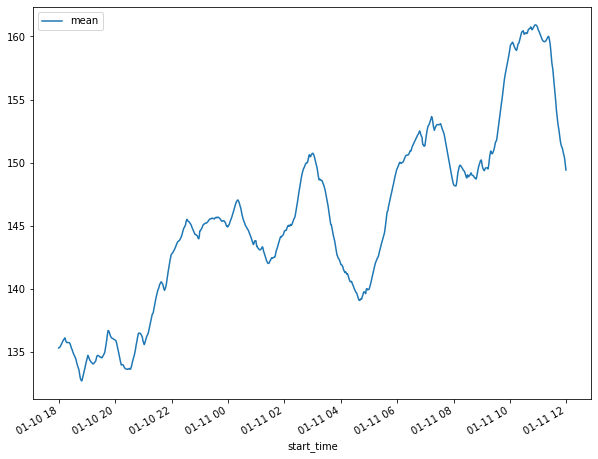

In [53]:
rolling_mean(PC_0192_ABF_s_extubated, 120)

The kendall tau correlation coefficient of the variance is 0.15456250026959056, and the p-value is 2.8095844295805452e-14.
The Hamid and Rao correction relusts in a p-value of 0.025435537988819812
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.025435537988819812, z=2.23472302568727, Tau=0.15455668829162805, s=90054.0, var_s=1623861417.0410023, slope=0.03878498005638803, intercept=86.67866159956267)


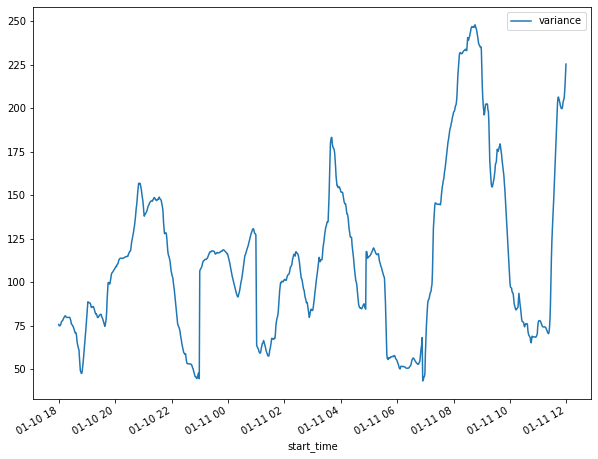

In [54]:
rolling_variance(PC_0192_ABF_s_extubated, 120)

The kendall tau correlation coefficient of the autocorrelation is -0.17301587982807728, and the p-value is 1.6660822432007323e-17.
The Hamid and Rao correction relusts in a p-value of 0.12982880134874808
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.12982880134874808, z=-1.5147773379222087, Tau=-0.17302028627329832, s=-100812.0, var_s=4429128161.297859, slope=-1.7026073544788663e-05, intercept=0.9748544013320567)


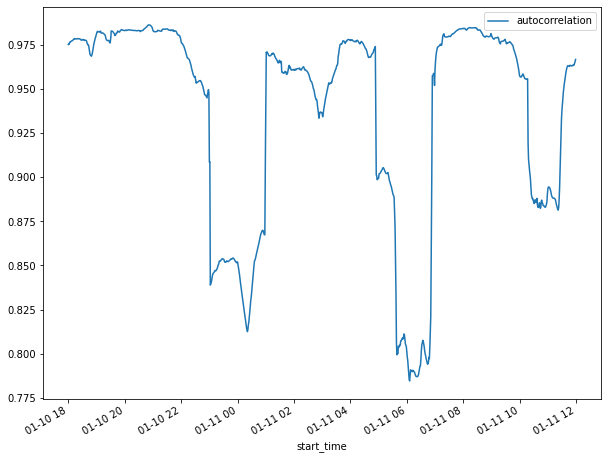

In [55]:
rolling_autocorrelation(PC_0192_ABF_s_extubated, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.04768054839535114, and the p-value is 0.01894735457530088.
The Hamid and Rao correction relusts in a p-value of 0.018170892243071002
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.018170892243071002, z=2.362117289446722, Tau=0.04767789105138503, s=27780.0, var_s=138302585.3613122, slope=7.599946817559381e-05, intercept=0.4229710342238002)


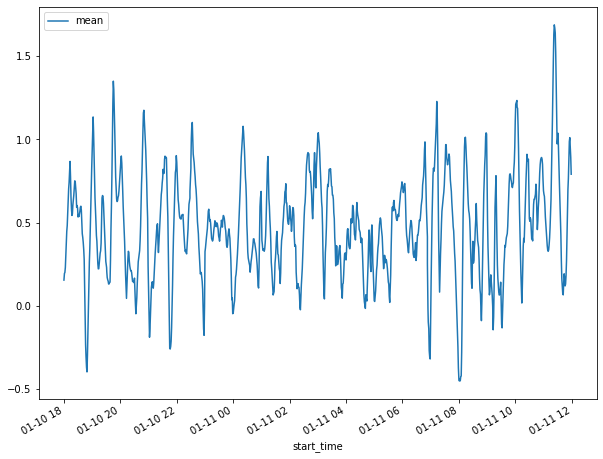

In [56]:
rolling_mean(PC_0192_ABF_s_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the variance is 0.1569481213248637, and the p-value is 1.1254759069926903e-14.
The Hamid and Rao correction relusts in a p-value of 0.08895094405789128
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.08895094405789128, z=1.700957627833549, Tau=0.15694916417807983, s=91448.0, var_s=2890359977.5904293, slope=0.016416171851890753, intercept=43.11301820802413)


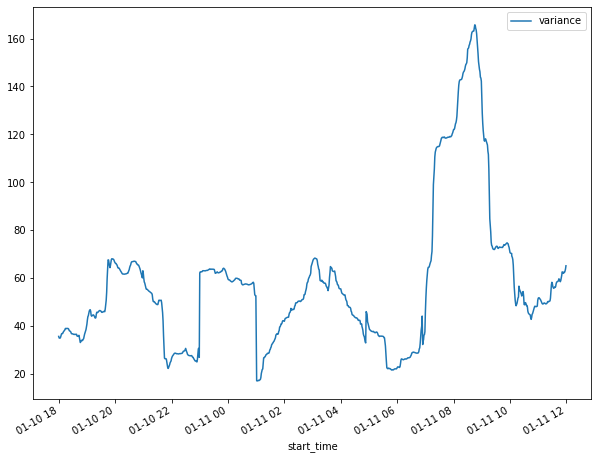

In [51]:
rolling_variance(PC_0192_ABF_s_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the autocorrelation is -0.14722027949659894, and the p-value is 4.3098851484543136e-13.
The Hamid and Rao correction relusts in a p-value of 0.31579547770171246
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.31579547770171246, z=-1.0031355220660836, Tau=-0.147224796622387, s=-85782.0, var_s=7312451363.430065, slope=-4.400778022741199e-05, intercept=0.946476323738596)


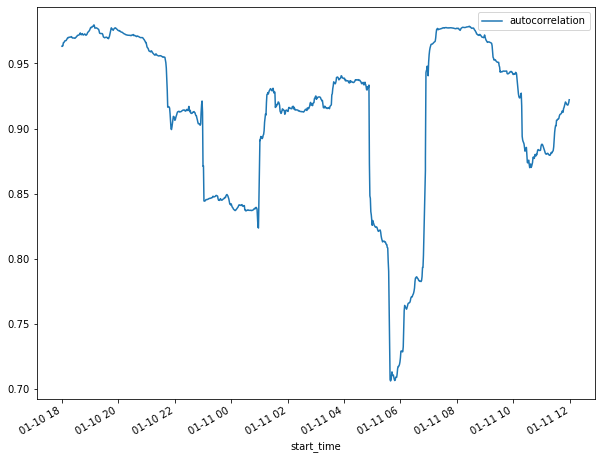

In [52]:
rolling_autocorrelation(PC_0192_ABF_s_residuals_no_anomalies, 120)

### Using mean (rather than systolic)

In [57]:
# smoothing and subtracting to obtain residuals

PC_0192_ABF_m_extubated_smoothed = PC_0192_ABF_m_extubated.copy()
PC_0192_ABF_m_residuals = PC_0192_ABF_m_extubated.copy()
PC_0192_ABF_m_extubated_smoothed['num_value'] = ndimage.gaussian_filter1d(PC_0192_ABF_m_extubated['num_value'], sigma=100)
PC_0192_ABF_m_residuals['num_value'] = PC_0192_ABF_m_extubated['num_value'] - PC_0192_ABF_m_extubated_smoothed['num_value']
PC_0192_ABF_m_residuals

,monitor,record_date_time,num_value
745631,ABPm,2017-01-10 18:00:01,-6
745634,ABPm,2017-01-10 18:00:06,-5
745637,ABPm,2017-01-10 18:00:11,-5
745640,ABPm,2017-01-10 18:00:16,-4
745643,ABPm,2017-01-10 18:00:21,-5
...,...,...,...
788200,ABPm,2017-01-11 13:59:36,-9
788203,ABPm,2017-01-11 13:59:42,-10
788206,ABPm,2017-01-11 13:59:46,-10
788209,ABPm,2017-01-11 13:59:52,-10


In [59]:
mu_residual_m = PC_0192_ABF_m_residuals['num_value'].mean()
sigma_residual_m = PC_0192_ABF_m_residuals['num_value'].std()

In [60]:
PC_0192_ABF_m_residuals_no_anomalies = PC_0192_ABF_m_residuals.copy()

for idx, val in enumerate(PC_0192_ABF_m_residuals_no_anomalies['num_value']):
    if not (mu_residual_m - 3*sigma_residual_m < val < mu_residual_m + 3*sigma_residual_m):
        if idx == 0:
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_m_residuals['num_value'].iloc[idx+1]
        if idx == 14240:
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = PC_0192_ABF_m_residuals['num_value'].iloc[idx-1]
        else:
            PC_0192_ABF_m_residuals_no_anomalies['num_value'].iloc[idx] = 0.5*(PC_0192_ABF_m_residuals['num_value'].iloc[idx+1] + PC_0192_ABF_m_residuals['num_value'].iloc[idx-1])


/Users/lucindakhalil/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


The kendall tau correlation coefficient of the autocorrelation is 0.22061578411329844, and the p-value is 1.8354342098128323e-27.
The Hamid and Rao correction relusts in a p-value of 0.15991238476365188
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.15991238476365188, z=1.4053662922829326, Tau=0.220615796519411, s=128544.0, var_s=8365998789.426693, slope=0.0075130814542914304, intercept=110.57304048672121)


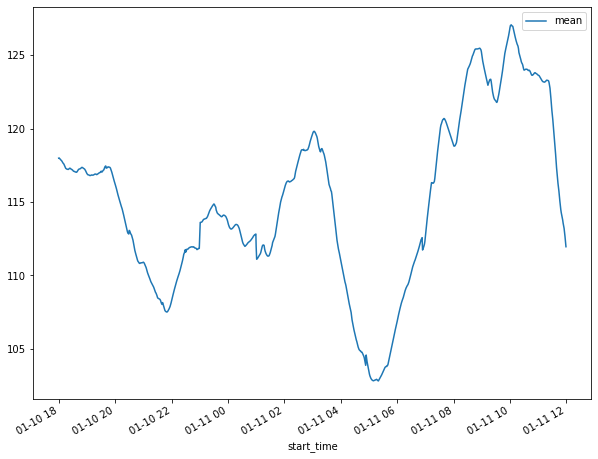

In [61]:
rolling_mean(PC_0192_ABF_m_extubated, 120)

The kendall tau correlation coefficient of the variance is 0.2700260959044129, and the p-value is 2.668002117336302e-40.
The Hamid and Rao correction relusts in a p-value of 0.005017516355250384
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.005017516355250384, z=2.8059070505266117, Tau=0.2700236844815158, s=157332.0, var_s=3143996438.7972054, slope=0.10227930976253982, intercept=46.16718137761373)


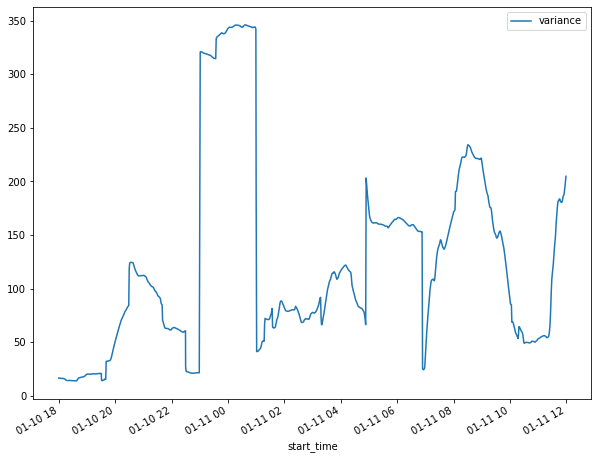

In [62]:
rolling_variance(PC_0192_ABF_m_extubated, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.4822773545755038, and the p-value is 1.5567147373368973e-124.
The Hamid and Rao correction relusts in a p-value of 0.00019451394127711907
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.00019451394127711907, z=3.7260368999134412, Tau=0.48227782926578106, s=281004.0, var_s=5687581198.912364, slope=0.00014982197654730321, intercept=0.8322685049600271)


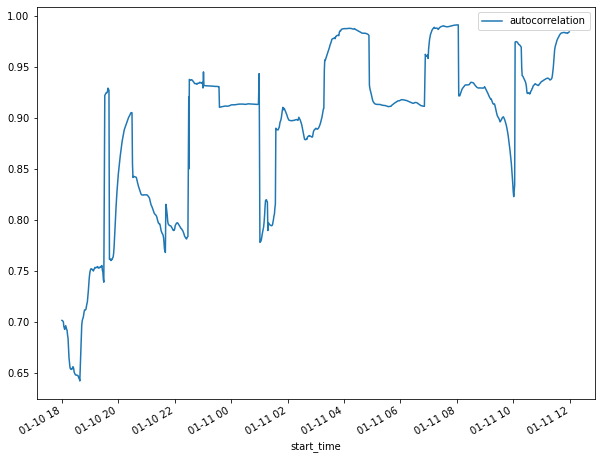

In [63]:
rolling_autocorrelation(PC_0192_ABF_m_extubated, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.05599193326600359, and the p-value is 0.005859312527740194.
The Hamid and Rao correction relusts in a p-value of 0.238565672120582
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.238565672120582, z=1.1785794660763718, Tau=0.05598805478323551, s=32622.0, var_s=766084719.5702814, slope=7.100298815501866e-05, intercept=0.44463408157004375)


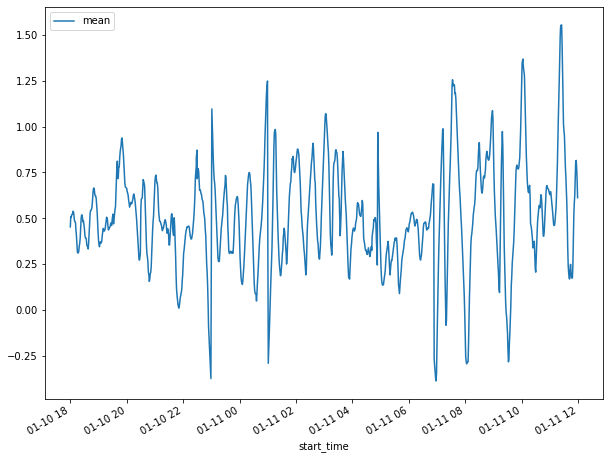

In [64]:
rolling_mean(PC_0192_ABF_m_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the variance is 0.12667282808067604, and the p-value is 4.54028979267843e-10.
The Hamid and Rao correction relusts in a p-value of 0.24945131774710472
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='no trend', h=False, p=0.24945131774710472, z=1.1516831039953201, Tau=0.12666735317337727, s=73804.0, var_s=4106596573.7179, slope=0.016397565759522968, intercept=27.950217709978332)


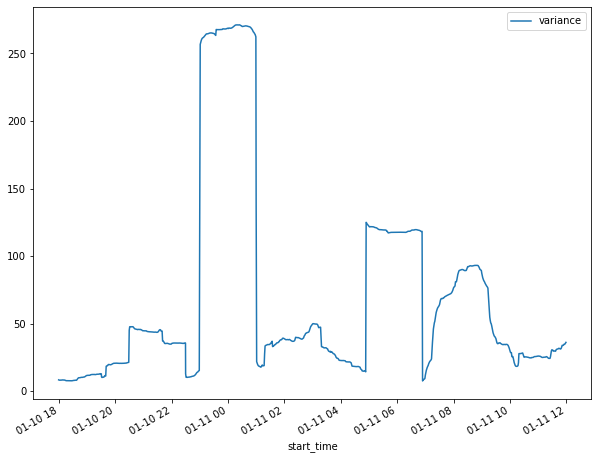

In [66]:
rolling_variance(PC_0192_ABF_m_residuals_no_anomalies, 120)

The kendall tau correlation coefficient of the autocorrelation is 0.34925947188734796, and the p-value is 3.2181703756063356e-66.
The Hamid and Rao correction relusts in a p-value of 0.013469137497566397
Output of Hamid Rao correction: Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.013469137497566397, z=2.471117977878995, Tau=0.34926372155287816, s=203502.0, var_s=6781818064.065598, slope=0.00010891988163504743, intercept=0.8394199400780094)


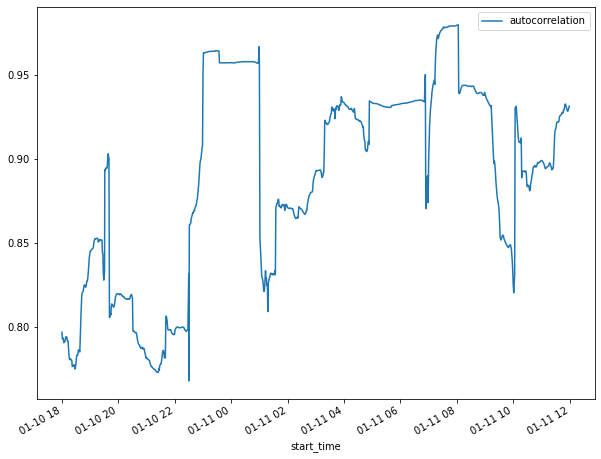

In [67]:
rolling_autocorrelation(PC_0192_ABF_m_residuals_no_anomalies, 120)